<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/FastAI_PETS_Cat_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [1]:
from comet_ml import Experiment
experiment = Experiment(
    project_name="fastai_cats_vs_dogs",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/portoforigin/fastai-cats-vs-dogs/b0f66b2e3e4b41198cbba81a7a854164



**Connect to Google Drive**

In [2]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *

2.2.7


## **PETS Dataset**

Load a view the PETS dataset:

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))

There are 7390 images


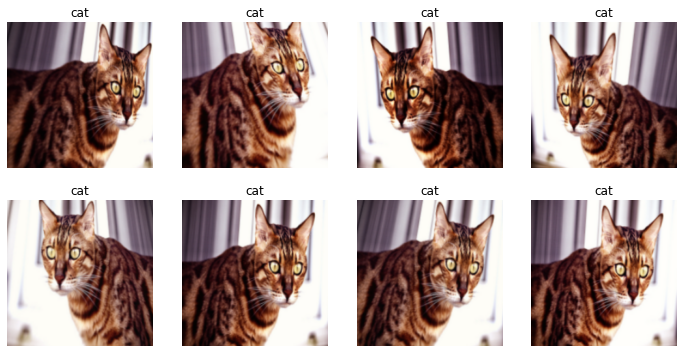

In [5]:
# Label is parsed from file name
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

# Label is parsed from file name
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=label_func,
                 #item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                 #item_tfms=Resize(224),
                 item_tfms=Resize(224, ResizeMethod.Squish),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"images")
dls.train.show_batch(max_n=8, nrows=2, unique=True)


**Load pre-trained Model**
Note: All custom functions need to be defined before calling load_leaner() (i.e. `def label_func`)

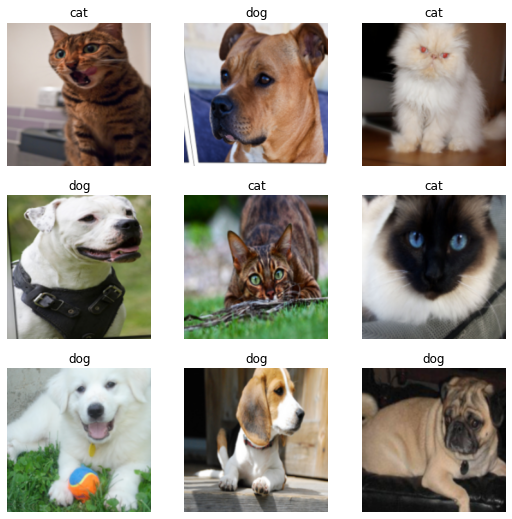

In [6]:
# View Data set (True == Cat, False == Dog)
dls.show_batch()

In [7]:
dls.vocab

['cat', 'dog']

TypeError: image_data cannot be None

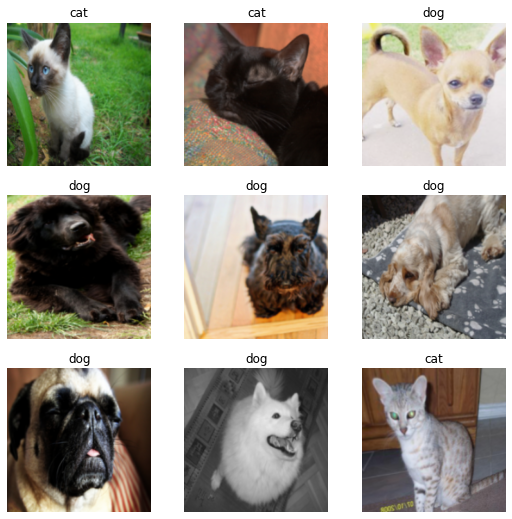

In [18]:
experiment.log_image(dls.show_batch())

## **Generate Fast AI Model for identifying Cats vs. Dogs**

In [17]:
model = resnet34

if dls.device.type == 'cpu':
    learn = cnn_learner(dls, model, metrics=fastai.metrics.accuracy)
else: # GPU:
    learn = cnn_learner(dls, model, metrics=fastai.metrics.accuracy).to_fp16()

with experiment.train():
    learn.fit_one_cycle(10, lr_max=3e-3)
    

epoch,train_loss,valid_loss,accuracy,time
0,0.822506,20.932447,0.328823,00:23
1,1.960767,82.141083,0.327470,00:23
2,3.512769,176.400009,0.557510,00:24
3,1.549546,20.795750,0.351150,00:23
4,0.784685,3.918143,0.367388,00:24
5,0.327737,1.798779,0.460758,00:24
6,0.244498,1.622625,0.497294,00:24
7,0.182051,1.003941,0.537212,00:24
8,0.144266,0.607011,0.679296,00:24
9,0.127631,0.613774,0.683356,00:24


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

In [ ]:
#Print top 20 losses. 
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
num_losses = 5
losses, indices = interp.top_losses(num_losses)
x = 1
for idx in indices:
    print(f"[{x}] {dls.valid_ds.items[idx]}")
    x += 1
interp.plot_top_losses(num_losses)

## **Upload Test Image**

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

for fname in uploaded.keys():
  is_cat,_,probs = learn_species.predict(fname)

  # Show Image
  img = cv2.imread(fname)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

  print(f"Is %s a cat?: %s" % (fname, is_cat))
  print(f"Probability it's a cat: {probs[1].item():.6f}")

## **Save Model to Drive**

In [ ]:
learn.export(dest/MODEL_NAME)